<a href="https://colab.research.google.com/github/Inkyu-Yang356/machine-learning-practice/blob/main/250528__solubility_prediction_model_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepChem 설치

Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [1]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [2]:
!pip install deepchem[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## 기타 모듈 설치
- rdkit 설치
- 레거시 옵티마이저 사용을 위한 tf_keras 설치(deepchem ver 2.4.0일 때만)

In [3]:
!pip install rdkit

In [4]:
!pip install tf_keras

## deepchem 버전 확인

In [5]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

## warning 메시지 생략

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# 분자 데이터 피처화

In [7]:
from rdkit import Chem

# SMILES와 확장 연결 지문(ECFP)
smiles_example = ['C1CCCCC1C', 'O1CCOCC1']
mols = [Chem.MolFromSmiles(s) for s in smiles_example] # rdkit 라이브러리를 사용하여 SMILES 문자열을 분자 객체로 변환
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
arr.shape

[00:31:16] DEPRECATION WARNING: please use MorganGenerator
[00:31:16] DEPRECATION WARNING: please use MorganGenerator


(2, 1024)

In [8]:
# 분자 표현자
feat = dc.feat.RDKitDescriptors()
arr = feat.featurize(mols)
arr.shape

(2, 217)

# 용해도 예측 모델 만들기
DeepChem 라이브러리를 사용하여 그래프 합성곱 신경망을 학습시켜 분자의 용해도를 예측하는 실습 진행

Delaney 데이터 : 분자의 SMILES 표현과 해당 분자의 용해도 값을 포함함

## 데이터 불러오기 및 확인

In [9]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2025-05-28 00:31:16--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.002s  

2025-05-28 00:31:16 (60.2 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [10]:
import pandas as pd
dataset = pd.read_csv("delaney-processed.csv")
print(dataset.shape)
dataset.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [11]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:19] DEPR

In [12]:
tasks

['measured log solubility in mols per litre']

In [13]:
transformers

In [14]:
train_dataset.X[0]

In [15]:
# ConvMol 특성의 구조 (원자가 11이고, 특성 벡터수가 75)
train_dataset.X[0].atom_features.shape

(11, 75)

In [16]:
train_dataset.X[0].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0.

In [17]:
# 11개 원자의 인접 노드 번호들 보기
train_dataset.X[0].get_adjacency_list()

[[9],
 [10],
 [4],
 [9],
 [6, 2],
 [7, 10],
 [10, 4],
 [8, 5],
 [9, 7],
 [0, 3, 8],
 [5, 1, 6]]

## 모델 생성 및 훈련

In [18]:
# 모델 생성 및 훈련
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, batch_normalize=False) # n_tasks : 출력층 지정, 출력층 1개노드이므로 회귀.
model.fit(train_dataset, nb_epoch=100)

0.06061887264251709

확인문제 1 : Regression 모드와 Classification 모드 중 Regression 모드 사용 이유를 적어보세요

-  특성을 이용해 연속형 변수인 용해도를 예측하는 모델이기 때문에 Regression이 적합합니다.

## 모델 평가

In [19]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score) # 피어슨 상관계수 평가지표 사용
print("Training set score")
print(model.evaluate(train_dataset, [metric], transformers))
print("Test set score")
print(model.evaluate(test_dataset, [metric], transformers))

Training set score
{'pearson_r2_score': np.float64(0.9381590219692321)}
Test set score
{'pearson_r2_score': np.float64(0.7301490375235165)}


확인문제 2 : 평가 결과에 대해 셜명하세요

- Training Set이 약 0.16 높은 것으로 보아 일부 과적합된 것으로 보입니다.

## 용해도 예측

In [20]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']

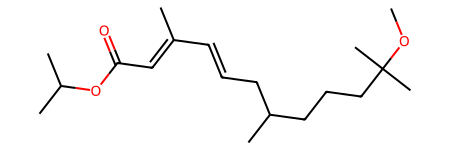

In [21]:
Chem.MolFromSmiles(smiles[0])

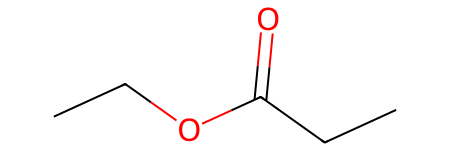

In [22]:
Chem.MolFromSmiles(smiles[1])

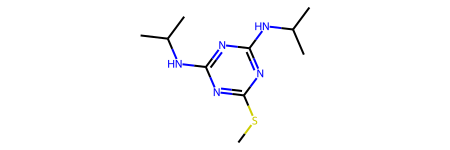

In [23]:
Chem.MolFromSmiles(smiles[2])

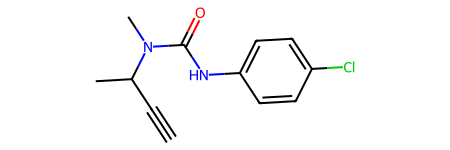

In [24]:
Chem.MolFromSmiles(smiles[3])

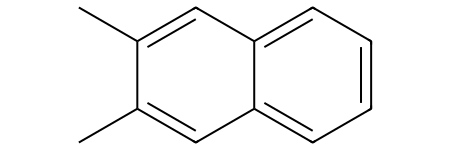

In [25]:
Chem.MolFromSmiles(smiles[4])

In [26]:
mols = [Chem.MolFromSmiles(s) for s in smiles] # SMILES 문자열 -> 분자 객체로 변환
featurizer = dc.feat.ConvMolFeaturizer() # 분자를 Graph 구조로 변환하는 featurizer 정의
x = featurizer.featurize(mols) # Node와 Edge로 이루어진 Graph 구조로 변환
predicted_solubility = model.predict_on_batch(x)

[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[00:31:49] DEPRECATION WARNING: please use GetValen

In [27]:
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.40411875]

Molecule: CCOC(=O)CC
Predicted solubility: [1.5211371]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [0.13983047]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [0.2432506]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.01985023]


# SMART 문자열
- 분자 내 원자들의 특정 패턴 찾기

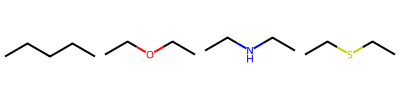

In [28]:
from rdkit.Chem.Draw import MolsToGridImage
smiles_for_smart = ["CCCCC", "CCOCC", "CCNCC", "CCSCC"]
mols_for_smart = [Chem.MolFromSmiles(s) for s in smiles_for_smart]
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(100, 100))

In [29]:
query = Chem.MolFromSmarts("CCC")
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (), (), ()]

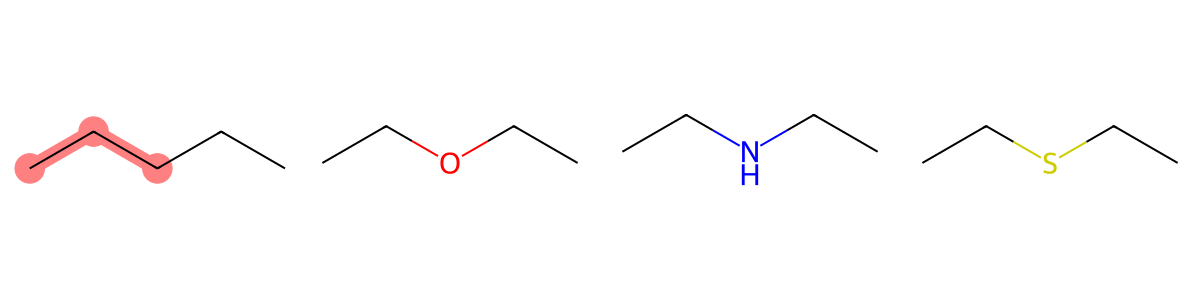

In [30]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

In [31]:
query = Chem.MolFromSmarts("C[C,O,S]C") # 2개의 탄소 원자 사이에 탄소 or 산소 or 질소 원자 하나가 결합해 있음
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (), (1, 2, 3)]

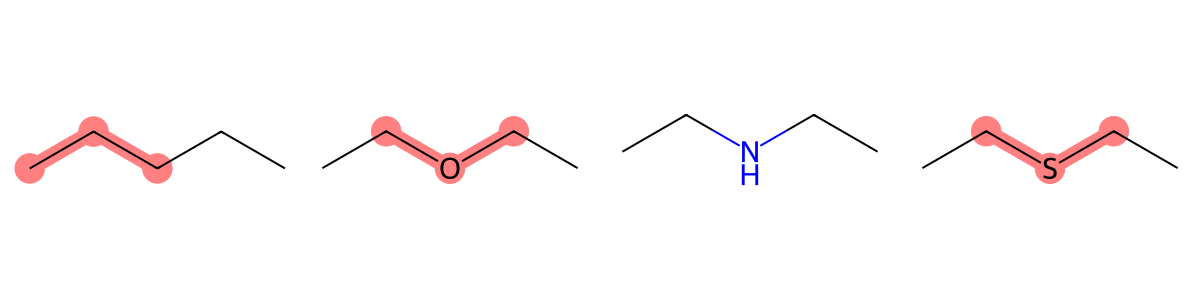

In [32]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)

### 확인 문제 3
- wildcard (*)를 사용해서 "?"에 들어갈 문자열을 작성하세요
> (*) 은 어떤 한 원소를 가리킵니다. 만약 탄소와 탄소사이에 들어갈 경우, O, NH, S이 들어가는 가능성을 보입니다.

In [61]:
wildcard_text = "C*C"
query = Chem.MolFromSmarts(wildcard_text)
match_list = [mole.GetSubstructMatch(query) for mole in mols_for_smart]
match_list

[(0, 1, 2), (1, 2, 3), (1, 2, 3), (1, 2, 3)]

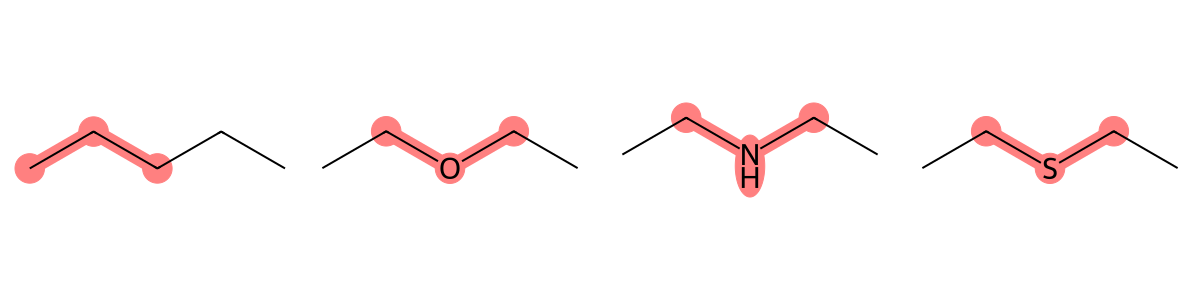

In [62]:
MolsToGridImage(mols_for_smart, molsPerRow=4, subImgSize=(300, 300), highlightAtomLists=match_list)